# **Training a Camembert Model for Text Difficulty Classification**

All the necessary import, including sentencepiece that is mandatory for a camembert model (sometimes after installation, we must relaunch the environment)

In [ ]:
!pip install transformers
!pip install PyTorch
!pip install TensorFlow
!pip install sentencepiece

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyTorch
  Running setup.py clean for PyTorch
Failed to build PyTorch
ERROR: Could not build wheels for PyTorch, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report
import joblib
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, CamembertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm import tqdm
import torch
import huggingface_hub

In [ ]:
from torch.utils.data import Dataset

Import the data from my GIT repo

In [ ]:
#load data

!git clone https://github.com/melvin2504/Detecting-the-difficulty-level-of-French-texts/ project_repo

Cloning into 'project_repo'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 77 (delta 6), reused 1 (delta 1), pack-reused 66
Receiving objects: 100% (77/77), 1.51 MiB | 10.75 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
df = pd.read_csv("/content/project_repo/data/training_data.csv")
unlabeled_df = pd.read_csv("/content/project_repo/data/unlabelled_test_data.csv")

# **Preprocessing and Model Initialization**
# Step 1: Initialize the Label Encoder

In [ ]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the difficulty labels
df['difficulty_encoded'] = label_encoder.fit_transform(df['difficulty'])


# Step 2: Split the Dataset

Here, we split the dataset into training and testing sets. The test set is 20% of the entire dataset. That is a parameters we can change to fine-tune the model

In [ ]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Compute Class Weights

This section calculates the class weights, which helps in dealing with imbalanced datasets by assigning different weights to different classes (when we augment the data for specific labels for example)

In [ ]:
from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(df['difficulty_encoded']), y=df['difficulty_encoded'])

# Convert class_weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to('cuda')  # If you are using a GPU

# Step 4: Define Loss Function

The CrossEntropyLoss function is defined with the computed class weights. This is particularly useful for classification tasks.

In [ ]:
# Define the loss function with class weights
loss_fn = CrossEntropyLoss(weight=class_weights)

# Step 5: Create a Custom Dataset Class

We create a custom dataset class for handling French text. This includes methods for initializing the dataset, calculating its length, and retrieving a specific item.

#### Class Definition
- **Purpose**: The `FrenchTextDataset` class, inheriting from PyTorch's `Dataset`, is tailored for handling French texts and their corresponding labels. It's specifically designed for our text classification task.

#### Initialization Method (`__init__`)
- **Functionality**: Initializes the dataset with texts, labels, a tokenizer, and a maximum token length. These parameters are essential for preparing the dataset for the model.
- **Parameters**:
  - `texts`: The French texts to be used for training/testing.
  - `labels`: Corresponding labels for each text.
  - `tokenizer`: A tokenizer for text processing, specific to our model's needs.
  - `max_token_len`: The maximum length for tokenization, ensuring uniformity in input size.

#### Length Method (`__len__`)
- **Purpose**: Returns the total number of texts in the dataset. This method is crucial for PyTorch to understand the size of the dataset.

#### Get Item Method (`__getitem__`)
- **Functionality**: Retrieves a specific item (text and label) from the dataset, based on an index. This method is called during dataset iteration.
- **Process**:
  - Retrieves the text and its corresponding label.
  - Uses the `encode_plus` method of the tokenizer to process the text:
    - Adds special tokens (like [CLS], [SEP]).
    - Applies padding or truncation to fit `max_token_len`.
    - Generates an attention mask.
  - Returns a dictionary containing `input_ids`, `attention_mask`, and `labels`, essential for model training in PyTorch.


In [ ]:
class FrenchTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_token_len=512):
        # Store the texts, labels, tokenizer, and maximum token length as attributes
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self):
        # Return the number of texts in the dataset
        return len(self.texts)

    def __getitem__(self, index):
        # Get the text and label at the specified index
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize the text with added special tokens, padding, and truncation
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add [CLS] and [SEP] tokens
            max_length=self.max_token_len,  # Truncate/pad to this length
            return_token_type_ids=False,  # Don't return token type ids
            padding='max_length',  # Pad to max_length
            truncation=True,  # Truncate to max_length
            return_attention_mask=True,  # Return attention mask
            return_tensors='pt'  # Return PyTorch tensors
        )

        # Return a dictionary with input_ids, attention_mask, and labels
        return {
            'input_ids': encoding['input_ids'].flatten(),  # Flatten the input_ids tensor
            'attention_mask': encoding['attention_mask'].flatten(),  # Flatten the attention mask tensor
            'labels': torch.tensor(label, dtype=torch.long)  # Convert label to a long tensor
        }

# Step 6: Initialize CamemBERT Tokenizer

Initializes the Camembert tokenizer, which is essential for tokenizing French text.

In [ ]:
# Initialize CamemBERT tokenizer
# Here, we are initializing the tokenizer specific to the CamemBERT model.
# 'camembert/camembert-base-ccnet' is the pre-trained model identifier.
tokenizer = CamembertTokenizer.from_pretrained('camembert/camembert-base-ccnet')

# Create the training dataset
# The train_dataset is created by passing the training sentences and their corresponding encoded difficulty labels.
# The tokenizer defined above is used for processing the texts in the dataset.
# This dataset will be used for training the model.
train_dataset = FrenchTextDataset(
    texts=train_df['sentence'].to_numpy(),  # Convert the sentence column to numpy array for processing
    labels=train_df['difficulty_encoded'].to_numpy(),  # Convert the encoded labels to numpy array
    tokenizer=tokenizer  # Use the initialized CamembertTokenizer
)

# Create the testing dataset
# Similarly to train_dataset, test_dataset is created for evaluating the model.
# It uses the test sentences and their labels, ensuring that the model can be evaluated on unseen data.
test_dataset = FrenchTextDataset(
    texts=test_df['sentence'].to_numpy(),  # Convert the sentence column of test data to numpy array
    labels=test_df['difficulty_encoded'].to_numpy(),  # Convert the encoded labels of test data to numpy array
    tokenizer=tokenizer  # Use the same tokenizer as for the training dataset
)


# Step 7: Create Data Loaders
Data loaders are created for both the training and testing datasets. These are used to feed data into the model in batches.

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Step 8: Initialize the CamemBERT Model
Finally, we initialize the CamemBERT model for sequence classification. The number of labels is set based on the unique values in the difficulty column.

In [ ]:
from transformers import CamembertForSequenceClassification

In [ ]:
model = CamembertForSequenceClassification.from_pretrained(
    'camembert/camembert-base-ccnet',
    num_labels=df['difficulty'].nunique()  # Adjust based on your number of classes
)
model = model.to('cuda')


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Step 9: Training and Evaluation Loop

In this section, we perform the training and evaluation of our CamemBERT model. We use the AdamW optimizer with a learning rate of `5e-5`. The training process involves iterating over our training data, performing a forward pass, computing the loss, and updating the model parameters through backpropagation.

We also define an `evaluate` function, which calculates the loss on the validation dataset. This function is crucial for monitoring the model's performance on unseen data and helps in preventing overfitting.

After each training epoch, we evaluate the model on the validation set. If the validation loss does not improve after a certain number of epochs (defined by the `patience` parameter), we stop the training early. This approach of early stopping is an effective regularization technique to combat overfitting.


In [ ]:
from torch.optim import AdamW

In [ ]:
# Initialize the optimizer with model parameters and learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define the evaluation function for the validation set
def evaluate(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0  # Initialize validation loss

    # Disable gradient calculations for validation to save memory and computations
    with torch.no_grad():
        for batch in val_loader:  # Iterate over each batch in the validation loader
            # Move input and labels to GPU for faster processing
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            # Forward pass without gradient calculation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()  # Accumulate the loss

    return val_loss / len(val_loader)  # Calculate average validation loss

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 0

# Training loop
for epoch in range(4):  # Iterate over epochs
    model.train()  # Set model to training mode
    for batch in train_loader:  # Iterate over each batch in the training loader
        # Move input and labels to GPU
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        # Forward pass and compute loss
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = loss_fn(outputs.logits, labels)  # Calculate loss
        loss.backward()  # Backpropagation

        optimizer.step()  # Update model parameters
        optimizer.zero_grad()  # Reset gradients

    # Evaluation after each epoch
    val_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch} completed. Validation Loss: {val_loss}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        patience = 0  # Reset patience
    else:
        patience += 1
        if patience > 1:  # Stop training if no improvement after certain epochs (can change the patience before breaking)
            print("Stopping early due to overfitting.")
            break

Epoch 0 completed. Validation Loss: 1.2656187097231546
Epoch 1 completed. Validation Loss: 0.9893474598725637
Epoch 2 completed. Validation Loss: 1.06071029206117
Epoch 3 completed. Validation Loss: 1.1581590235233308
Stopping early due to overfitting.


### Prediction and Performance Evaluation

After training the CamemBERT model, we proceed to evaluate its performance on the test set. This step is crucial for understanding how well the model generalizes to new, unseen data.

First, we set the model to evaluation mode using `model.eval()`. This disables dropout and batch normalization layers for the inference phase.

We then iterate over the test dataset using our DataLoader. For each batch, we perform a forward pass through the model without calculating gradients, as we are not training during this phase.

The model outputs logits, which are then converted into predicted class labels using the `argmax` function. These predictions, along with the actual labels from the test data, are used to generate a classification report. This report provides a comprehensive overview of the model's performance, including metrics like precision, recall, and F1-score for each class.


In [ ]:
model.eval()  # Set the model to evaluation mode

# Initialize lists to store predictions and actual labels
predictions, true_labels = [], []

# Iterate over the test data
for batch in test_loader:
    # Move the batch to GPU for faster processing
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Disable gradient calculations as we are in inference mode
    with torch.no_grad():
        outputs = model(**batch)  # Forward pass with the batch

    logits = outputs.logits  # Extract the logits from the model output
    predictions.extend(logits.argmax(dim=1).tolist())  # Get the predicted labels
    true_labels.extend(batch['labels'].tolist())  # Append the actual labels

# Print the classification report comparing predictions and true labels
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.77      0.74      0.75        91
           1       0.50      0.44      0.47        72
           2       0.61      0.50      0.55        92
           3       0.46      0.71      0.56        70
           4       0.55      0.49      0.52        71
           5       0.68      0.65      0.67        84

    accuracy                           0.59       480
   macro avg       0.59      0.59      0.59       480
weighted avg       0.61      0.59      0.59       480



### Classification Report Analysis

#### Key Metrics:
- **Precision**: Measures the ratio of correctly predicted positive observations to the total predicted positives. High precision relates to a low false positive rate.
  - Example: Class 0 has a precision of 0.77, meaning 77% of instances predicted as class 0 are correctly identified.

- **Recall (Sensitivity)**: Indicates the proportion of actual positives correctly identified.
  - Example: Class 3 has a recall of 0.71, meaning the model correctly identifies 71% of all actual class 3 instances.

- **F1-Score**: A weighted average of Precision and Recall, useful in imbalanced class distributions. A high F1 score implies low false positives and negatives.
  - Example: Class 3 has the highest F1-score of 0.56 among the classes, indicating a balanced precision and recall.

- **Support**: The actual number of occurrences of each class in the dataset.
  - Example: Class 0 appears 91 times.

- **Accuracy**: The overall rate of correctly predicted observations. The model's accuracy is 0.59 (59%), indicating its general effectiveness.

- **Macro Avg**: The unweighted average of precision, recall, and F1-score across classes, standing at 0.59 for this model.

- **Weighted Avg**: Accounts for class imbalance by weighting each class's metrics by its support, showing a slightly better performance at around 0.61.


### Visualizing the Confusion Matrix

A confusion matrix is a useful tool for understanding the performance of a classification model. It helps in visualizing the model's predictions in comparison with the actual labels.

To create the confusion matrix, we use the `confusion_matrix` function from `sklearn.metrics`, passing in the true labels and the predictions made by the model.

We then use Matplotlib and Seaborn libraries to plot the confusion matrix. `plt.figure(figsize=(10, 7))` sets the size of the plot for better visibility. `sns.heatmap` is used to create a heatmap representation of the confusion matrix. The parameters `annot=True` and `fmt='g'` ensure that the individual counts are displayed in each cell of the


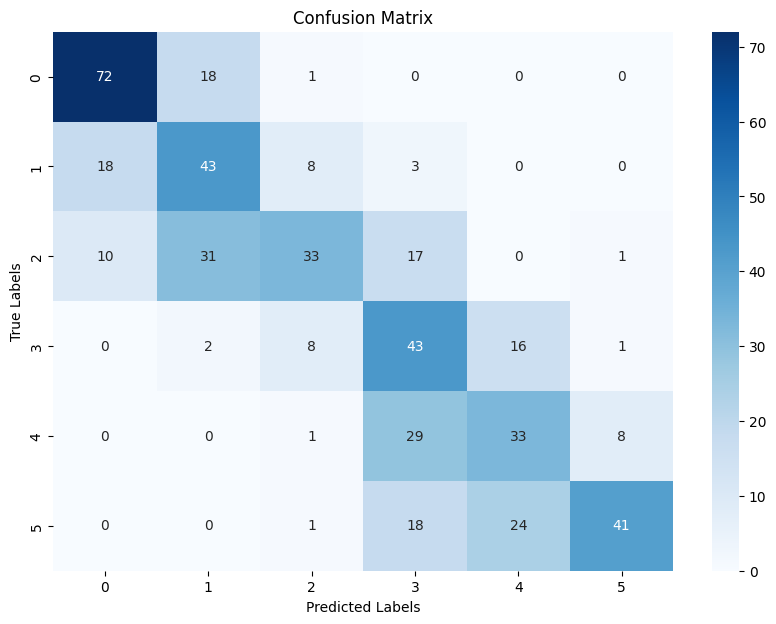

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  # Set the figure size for the plot
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')  # Create a heatmap for the confusion matrix
plt.xlabel('Predicted Labels')  # Label for the x-axis
plt.ylabel('True Labels')  # Label for the y-axis
plt.title('Confusion Matrix')  # Title for the plot
plt.show()  # Display the plot


#### Analysis and Insights:
- The model is most precise in predicting Class 0 and most sensitive in identifying Class 3.
- The F1-score is fairly consistent across classes, with Class 3 achieving the highest score.
- A moderate overall accuracy of 59% may be acceptable but also indicates potential areas for improvement.
- Class imbalance (in quality maybe) is evident, impacting the macro and weighted averages.
- Classes 1 and 2 show lower performance in precision and recall, suggesting areas for focused improvement.


# Step 10: Retraining Model on Full Dataset

After the initial training and evaluation phases, we now proceed to retrain the CamemBERT model on the entire dataset. This process is aimed at leveraging the full range of data available, enhancing the model's ability to generalize and perform effectively on real-world data.

The steps for retraining include:

1. **Initializing the CamemBERT Tokenizer**: We continue to use the `CamembertTokenizer` for consistent text preprocessing.

2. **Preparing the Full Dataset**: The `FrenchTextDataset` is now initialized with the complete dataset, ensuring that all available text data and labels are included.

3. **Data Loader Creation**: A DataLoader is set up for the full dataset, with an appropriate batch size and shuffling enabled to ensure diverse mini-batch training.

4. **Training Loop**: The model undergoes training for a specified number of epochs. In each epoch, it performs the following steps on each batch of data:
    - Forward pass: Processes the input data through the model.
    - Loss Computation: Calculates the loss using the `CrossEntropyLoss` function with class weights.
    - Backward Pass: Performs backpropagation to update the model's weights.
    - Optimization Step: Applies gradient descent to optimize the model's parameters.

By retraining on the full dataset, we aim to enhance the model's performance and prepare it for deployment in practical applications.


In [ ]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert/camembert-base-ccnet')

full_dataset = FrenchTextDataset(
    texts=df['sentence'].to_numpy(),
    labels=df['difficulty_encoded'].to_numpy(),
    tokenizer=tokenizer
)

# Create data loaders
loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

In [ ]:
for epoch in range(3):  # Adjust the number of epochs as needed
    model.train()
    for batch in loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Compute loss
        loss = loss_fn(outputs.logits, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

# Step 11: Preparing the Unlabeled Data

In practical applications, we often deal with unlabeled data. To make predictions on such data using our trained CamemBERT model, we need to prepare it in a format that the model can process. The following steps are taken to achieve this:

1. **Custom Dataset for Unlabeled Data**: We define a class `UnlabeledFrenchTextDataset`, similar to our labeled dataset class but tailored for unlabeled texts. It handles the tokenization and preparation of the texts without needing labels.

2. **Initializing the Unlabeled Dataset**: We initialize this dataset with our unlabeled texts and the previously used tokenizer. This ensures consistency in text processing.

3. **DataLoader for Unlabeled Data**: A DataLoader is created for the unlabeled dataset. This DataLoader will enable efficient and manageable processing of the data in batches, which is particularly useful when dealing with large amounts of data.

By preparing the unlabeled data in this way, we ensure that it is in the correct format for the CamemBERT model to make predictions. This step is crucial for applying the model to real-world scenarios where labeled data might not always be available.


In [ ]:
# Custom dataset class for handling unlabeled French text data.
class UnlabeledFrenchTextDataset(Dataset):

    # Constructor to initialize the dataset.
    # - `texts`: array of text data.
    # - `tokenizer`: tokenizer used for encoding the texts.
    # - `max_token_len`: maximum length of tokens for each text.
    def __init__(self, texts, tokenizer, max_token_len=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    # Returns the total number of texts in the dataset.
    def __len__(self):
        return len(self.texts)

    # Retrieves a single item from the dataset by index.
    def __getitem__(self, index):
        text = self.texts[index]  # Get the text at the specified index.

        # Encode the text into a format suitable for the model.
        # - Adds special tokens (like [CLS], [SEP]).
        # - Pads or truncates the text to `max_token_len`.
        # - Generates an attention mask for the input.
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Returns a dictionary with encoded inputs and attention mask.
        # These are needed for model inference.
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Create an instance of the UnlabeledFrenchTextDataset class.
# This dataset is used for processing the unlabeled texts.
unlabeled_dataset = UnlabeledFrenchTextDataset(
    texts=unlabeled_df['sentence'].to_numpy(),  # Convert the sentences from DataFrame to numpy array.
    tokenizer=tokenizer  # Use the same tokenizer as in the training phase.
)

# DataLoader to efficiently handle batches of the unlabeled data.
# - `batch_size`: Number of samples per batch to load.
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16)



# Step 12: Predicting Unlabeled Data

#### Evaluation Mode
Firstly, we set our model to evaluation mode using `model.eval()`. This step is crucial as it prepares the model for inference, disabling certain layers like Dropout and BatchNorm that are only active during training.

#### Making Predictions
We then process the unlabeled data batch-wise. For each batch:
- We transfer the batch data to CUDA for accelerated computation.
- We use a `torch.no_grad()` context to perform inference without computing gradients, which is more memory efficient and faster.
- The model's forward pass is computed with the batch data, yielding logits.

#### Processing the Output
- We apply `argmax` to the logits to get the most likely class label predictions.
- These predictions are collected in a list, `predictions`.

#### Label Conversion
Finally, we convert our numeric predictions back to their original label format using the `LabelEncoder`'s `inverse_transform` method. This step provides us with the class labels in a human-readable form.


In [ ]:
# Switching the model to evaluation mode. This is essential as it disables
# layers like Dropout and BatchNorm, which behave differently during training.
model.eval()

# List to store the predictions.
predictions = []

# Iterate over each batch in the DataLoader.
for batch in unlabeled_loader:
    # Move the batch data to the GPU for faster computation.
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Disable gradient calculations. This reduces memory usage and speeds up computation.
    with torch.no_grad():
        # Forward pass through the model.
        outputs = model(**batch)

    # Extract the logits (raw model outputs prior to activation function) from the model outputs.
    logits = outputs.logits
    # Find the maximum logit to get the most likely class label for each instance in the batch.
    preds = logits.argmax(dim=1).tolist()
    # Extend the main predictions list with the batch predictions.
    predictions.extend(preds)

# Convert the numerical predictions back to their original categorical label form.
predicted_labels = label_encoder.inverse_transform(predictions)



#Step 13: Preparing Submission File for Kaggle

#### Creating the Submission DataFrame
We prepare a DataFrame named `submission_df` for submission. This DataFrame includes:
- `id`: The unique identifiers from our `unlabeled_df`.
- `difficulty`: The predicted labels obtained from the model for each text.

#### Saving to CSV
The DataFrame is then saved to a CSV file using the `to_csv` method. The filename 'submission_v39_Camembert-baseCCnet-epoch4-batch16-lr5e-5-weights-split01.csv' reflects the model version, training details, and the data split used. By setting `index=False`, we ensure that the DataFrame's index is not included in the CSV file, keeping only the relevant columns (`id` and `difficulty`).

This step finalizes the process by creating a ready-to-submit file containing our model's predictions.


In [ ]:
# Prepare the DataFrame for submission
submission_df = pd.DataFrame({
    'id': unlabeled_df['id'],
    'difficulty': predicted_labels
})

# Save the DataFrame to a CSV file
submission_file = 'submission_v39_Camembert-baseCCnet-epoch4-batch16-lr5e-5-weights-split01.csv'
submission_df.to_csv(submission_file, index=False)

# Step 14: Saving the Trained Model

#### Model Save Path
We define the path where the trained model will be saved. In this case, it's specified as `"/content/modelforApp.pth"`. This path points to a location in the Colab environment, typically in the content directory. The `.pth` extension is commonly used for PyTorch model files.

#### Saving the Model's State
We use `torch.save` to save the model's state dictionary (`state_dict`). The state dictionary contains all the parameters of the model, such as the weights and biases of the neural network layers. Saving the state dictionary enables us to reload the model later with these exact parameters.

#### Confirmation Message
After saving the model, a confirmation message is printed, indicating the successful save operation and the path where the model is stored. This is helpful for verification and for locating the saved model file for future use.



In [ ]:
model_path = "/content/modelforApp.pth"

# Save the model's state_dict
torch.save(model.state_dict(), model_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at /content/modelforApp.pth
